In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import argparse
from prophet import Prophet

In [17]:
parser = argparse.ArgumentParser()

parser.add_argument('strings', metavar='STRING', nargs='*', help='String for searching')
parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')
parser.add_argument('--predict_periods', help="How many periods to the future to predict.", type=int, default=365)
parser.add_argument('--data_file', help="File name with dataset.", type=str, default='accidents_daily.csv')

args = parser.parse_args()

periods_to_predict = int(args.predict_periods)
data_file = args.data_file

In [18]:
dataset_df = pd.read_csv(data_file, index_col='date', parse_dates=True)

dataset_df

,y
date,
2016-01-01,450
2016-01-02,148
2016-01-03,99
2016-01-04,344
2016-01-05,271
...,...
2022-12-27,169
2022-12-28,157
2022-12-29,151


In [19]:
# split the data to training set and test set

column_names = ['ds', 'y']  # ds = date, y = number of accidents in that day/month

# train set = years 2016-2021, test set = year 2022
dataset_train = dataset_df[:len(dataset_df) - periods_to_predict].reset_index()  # reserve last 12 observation as test set
dataset_train.columns = column_names
dataset_test = dataset_df[len(dataset_df) - periods_to_predict:].reset_index()
dataset_test.columns = column_names

print(dataset_train)
print(dataset_test)

             ds    y
0    2016-01-01  450
1    2016-01-02  148
2    2016-01-03   99
3    2016-01-04  344
4    2016-01-05  271
...         ...  ...
2187 2021-12-27  214
2188 2021-12-28  199
2189 2021-12-29  181
2190 2021-12-30  198
2191 2021-12-31  141

[2192 rows x 2 columns]
            ds    y
0   2022-01-01  543
1   2022-01-02  123
2   2022-01-03  234
3   2022-01-04  246
4   2022-01-05  219
..         ...  ...
360 2022-12-27  169
361 2022-12-28  157
362 2022-12-29  151
363 2022-12-30  157
364 2022-12-31  111

[365 rows x 2 columns]


In [20]:
dataset_df.reset_index(inplace=True)
dataset_df.columns = column_names

print(dataset_df)

             ds    y
0    2016-01-01  450
1    2016-01-02  148
2    2016-01-03   99
3    2016-01-04  344
4    2016-01-05  271
...         ...  ...
2552 2022-12-27  169
2553 2022-12-28  157
2554 2022-12-29  151
2555 2022-12-30  157
2556 2022-12-31  111

[2557 rows x 2 columns]


In [21]:
# create a dataframe that will contain forecasts from all applied algorithms
predict_df = pd.DataFrame(dataset_df['ds'])

# add new dates to the predict_df in the length of months from the arguments
last_date = dataset_df['ds'].max()
next_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(next_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

predict_df = pd.concat([predict_df, new_rows])

# add original values to the predict_df dataframe
predict_df['original'] = list(dataset_train['y']) + list(dataset_test['y']) + [None] * periods_to_predict
predict_df.set_index('ds', inplace=True)

predict_df

,original
ds,
2016-01-01,450.0
2016-01-02,148.0
2016-01-03,99.0
2016-01-04,344.0
2016-01-05,271.0
...,...
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN


In [7]:
# Prophet

prophet_model = Prophet()  # create new object for forecasting
prophet_model.fit(dataset_train)  # fit the training data
future = prophet_model.make_future_dataframe(periods=periods_to_predict + periods_to_predict, freq='1d')  # set length of forecast
forecast = prophet_model.predict(future)  # predict for the number of observations set in the previous step

16:03:02 - cmdstanpy - INFO - Chain [1] start processing
16:03:03 - cmdstanpy - INFO - Chain [1] done processing


Text(83.09722222222221, 0.5, 'number of accidents')

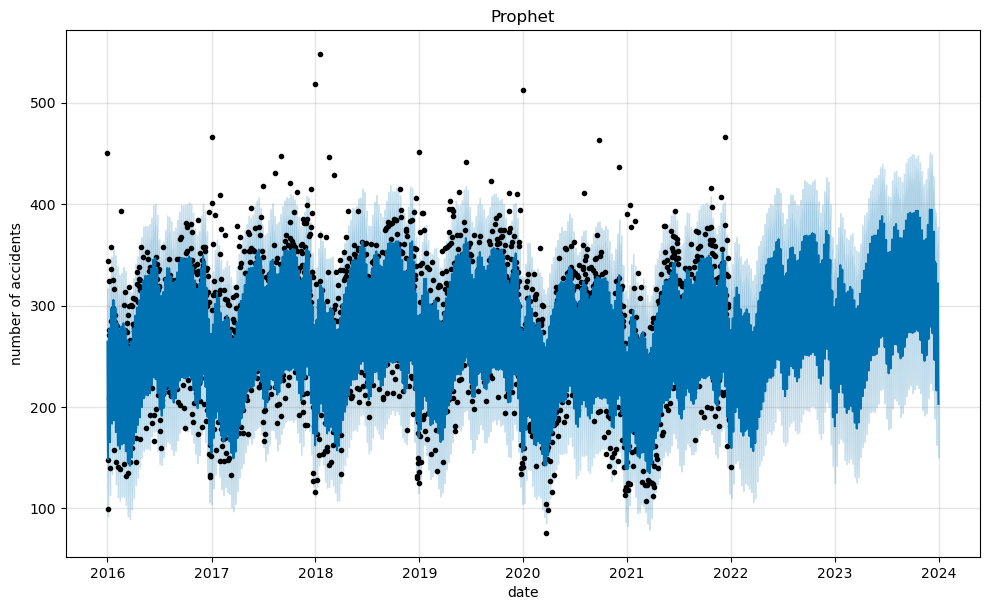

In [8]:
fig1 = prophet_model.plot(forecast)  # plot the forecast
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

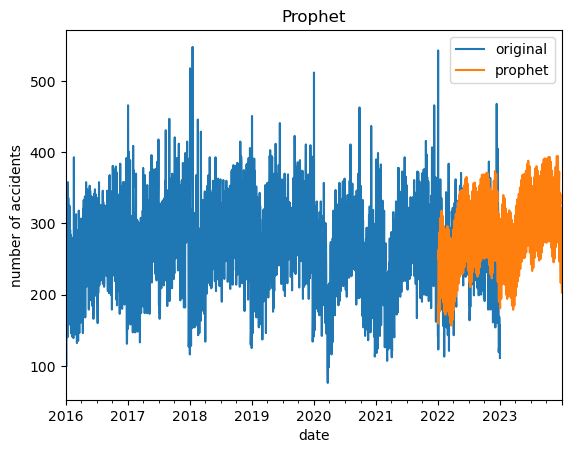

In [9]:
predict_df['prophet'] = [None]*len(dataset_train) + list(forecast['yhat'].tail(periods_to_predict + periods_to_predict))  # add the forecast to predict_df

predict_df[['original', 'prophet']].plot()
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [10]:
# # use grid search to find the most optimal hyperparameters for SVR model
# param_grid = {
#     'kernel': ['rbf', 'sigmoid'],
#     'C': [0.1, 1, 10],
#     'epsilon': [0.01, 0.1, 1],
#     'gamma': ['scale', 'auto', 0.1, 1]
# }

# cv = TimeSeriesSplit(n_splits=5)

# svr = SVR()

# grid_search = GridSearchCV(svr, param_grid, cv=cv)
# grid_search.fit(dataset_train['ds'].values.reshape(-1, 1), dataset_train['y'].values)  # fit the training data

# print("Best parameters: ", grid_search.best_params_)  # print the most optimal hyperparameter values
# print("Best score: ", grid_search.best_score_)

In [11]:
# # SVR
# svr_model = SVR(kernel='rbf', gamma='auto', C=10, epsilon=1)  # create model with values from the GridSearchCV
# svr_model.fit(dataset_train.index.values.reshape(-1, 1), dataset_train['y'].values)  # fit the training data

# y_pred = svr_model.predict(dataset_test.index.values.reshape(-1, 1))

# y_pred

In [12]:
# # plot the whole dataset + add predicted values for 2022
# svr_predict_df = pd.DataFrame(dataset_df)
# svr_predict_df['forecast_value'] = [None]*len(dataset_train) + list(y_pred)

# svr_predict_df.set_index('ds', inplace=True)
# svr_predict_df.columns = ["original", "predicted"]
# svr_predict_df.plot()
# plt.title("SVR by month")
# plt.xlabel("month")
# plt.ylabel("number of accidents")

In [13]:
from scalecast.Forecaster import Forecaster

In [14]:
# create a Forecaster object that will make forecasts from multiple models
f_model = Forecaster(
    y=np.array(dataset_df.reset_index()['y']),
    current_dates=np.array(dataset_df.reset_index()['ds'])
)
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [15]:
f_model.set_test_length(periods_to_predict)  # reserve last n observations as a test set
f_model.generate_future_dates(periods_to_predict)  # predict 12 months into the future
f_model.set_validation_length(f_model.test_length)
f_model.auto_Xvar_select()
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=365
    Xvars=['lnt', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53']
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [16]:
forecaster_estimators = ['arima', 'svr', 'xgboost', 'catboost', 'rnn', 'lstm']  # models that will by predicted by Forecaster
for estimator in forecaster_estimators:
    f_model.set_estimator(estimator)
    f_model.tune()  # find optimal hyperparameters for selected method
    f_model.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {estimator}:')
    print(f_model.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 1, 1, 7)}
Hyperparameter values for svr:
{'kernel': 'linear', 'C': 3, 'epsilon': 1, 'gamma': 'scale'}


KeyboardInterrupt: 

In [ ]:
f_model.plot()  # plots future values
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")
f_model.plot_test_set()  # plots values from test set
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [ ]:
# add forecasts from models in Forecaster to predict_df
for method in forecaster_estimators:
    result = f_model.export_fitted_vals(method)
    predict_df[method] = [None] * len(dataset_train) + list(result.tail(periods_to_predict + periods_to_predict)['FittedVals'])

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.metrics import accuracy_score

In [13]:
# split datetime to day, month, and year parts for models with GA
dataset_ga = dataset_df
dataset_ga['day'] = dataset_df['ds'].dt.day
dataset_ga['month'] = dataset_df['ds'].dt.month
dataset_ga['year'] = dataset_df['ds'].dt.year
dataset_ga

,ds,y,day,month,year
0,2016-01-01,450,1,1,2016
1,2016-01-02,148,2,1,2016
2,2016-01-03,99,3,1,2016
3,2016-01-04,344,4,1,2016
4,2016-01-05,271,5,1,2016
...,...,...,...,...,...
2552,2022-12-27,169,27,12,2022
2553,2022-12-28,157,28,12,2022
2554,2022-12-29,151,29,12,2022
2555,2022-12-30,157,30,12,2022


In [15]:
# split data to training and testing sets
X = dataset_ga[['day', 'month', 'year']]
y = dataset_ga['y']
X_train_ga = X[:len(X) - periods_to_predict]
X_test_ga = X[len(X) - periods_to_predict:]
y_train_ga = y[:len(y) - periods_to_predict]  # test set = observations from the last year
y_test_ga = y[len(y) - periods_to_predict:]
X_train_ga.shape, X_test_ga.shape, y_train_ga.shape, y_test_ga.shape

((2192, 3), (365, 3), (2192,), (365,))

In [16]:
rf = RandomForestRegressor(random_state=111)

In [ ]:
# adapters used in GA Search
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [ ]:
# grid with attributes for random forest, for genetic algorithm
rf_grid_ga = {
    'n_estimators': Integer(100, 600),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'max_depth': Integer(2,20),
    'criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'min_samples_split': Continuous(0.1, 0.9),
    'bootstrap': Categorical([True, False])
}

In [ ]:
rf_estimator_ga = GASearchCV(estimator=rf,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [ ]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)  # fit the training data

In [ ]:
rf_estimator_ga.best_params_

In [20]:
# prepare testing data with future dates in the length of argument months_to_predict
last_date = dataset_ga.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
X_test_ga = pd.concat([X_test_ga, new_rows])

In [21]:
X_test_ga = X_test_ga[['day', 'month', 'year']]
X_test_ga

,day,month,year
2192,1,1,2022
2193,2,1,2022
2194,3,1,2022
2195,4,1,2022
2196,5,1,2022
...,...,...,...
361,27,12,2023
362,28,12,2023
363,29,12,2023
364,30,12,2023


In [ ]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)  # predict future dates

In [ ]:
y_predict_rf_ga

In [ ]:
plot_fitness_evolution(rf_estimator_ga)

In [22]:
# prepare dataframe with forecast values (predict_df will contain all hyperparameter optimization techniques)
rf_predict_df = dataset_df[['ds']]

last_date = rf_predict_df.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

rf_predict_df = pd.concat([rf_predict_df, new_rows])

rf_predict_df['original'] = list(y_train_ga) + list(y_test_ga) + [None] * periods_to_predict
rf_predict_df['predicted - GA'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)
rf_predict_df.set_index('ds', inplace=True)

Text(0, 0.5, 'number of accidents')

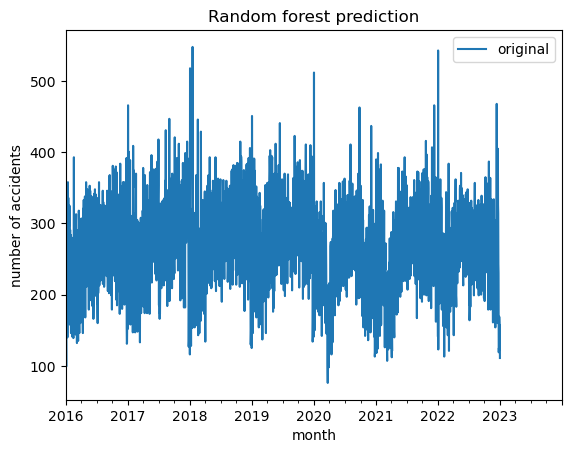

In [23]:
# plot results with random forest and G
rf_predict_df.plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [ ]:
# create grid for randomized searach cv
rf_grid_randomized = {
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.9],
    'bootstrap': [True, False]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf = RandomForestRegressor(random_state=111)
rf_estimator_randomized = RandomizedSearchCV(estimator=rf,
                                             scoring='r2',
                                             param_distributions = rf_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [ ]:
rf_estimator_randomized.fit(X_train_ga, y_train_ga)

In [ ]:
rf_estimator_randomized.best_params_

In [ ]:
y_predict_rf_randomized = rf_estimator_randomized.predict(X_test_ga)

In [ ]:
y_predict_rf_randomized

In [ ]:
rf_predict_df['predicted - randomized'] = [None] * len(X_train_ga) + list(y_predict_rf_randomized)

In [ ]:
# plot results with random forest and randomized search cv
rf_predict_df[['original', 'predicted - randomized']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [ ]:
# grid for grid search cv
rf_grid_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 10, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.5, 0.9],
    'bootstrap': [True, False]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_estimator_grid = GridSearchCV(estimator=rf,
                                 scoring='r2',
                                 param_grid = rf_grid_grid,
                                 n_jobs=-1,
                                 error_score='raise'
                                )

In [ ]:
y_predict_rf_grid = rf_estimator_grid.fit(X_train_ga, y_train_ga)

In [ ]:
rf_estimator_grid.best_params_

In [ ]:
y_predict_rf_grid = rf_estimator_grid.predict(X_test_ga)

In [ ]:
y_predict_rf_grid

In [ ]:
rf_predict_df['predicted - grid'] = [None] * len(X_train_ga) + list(y_predict_rf_grid)

In [ ]:
# plot results with random forest and grid search cv
rf_predict_df[['original', 'predicted - grid']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [ ]:
# r2 score with GA search cv
rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

In [ ]:
# r2 score with randomized search cv
rf_estimator_randomized.score(X_test_ga[:periods_to_predict], y_test_ga)

In [ ]:
# r2 score with grid search cv
rf_estimator_grid.score(X_test_ga[:periods_to_predict], y_test_ga)

In [ ]:
# plot all 3 techniques for random forest on one plot
rf_predict_df.plot()
plt.title("Random Forest")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [ ]:
predict_df['random forest + GA'] = list(rf_predict_df['predicted - GA'])
predict_df['random forest + randomized'] = list(rf_predict_df['predicted - randomized'])
predict_df['random forest + grid'] = list(rf_predict_df['predicted - grid'])

predict_df

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
# # pipeline with data scaling and random forest
# steps = [
#     ('scaler', MinMaxScaler()),  # Data preprocessing step
#     ('rf', RandomForestRegressor(random_state=111))  # Random Forest Regressor step
# ]

In [ ]:
# pipeline = Pipeline(steps)

In [ ]:
# # GA search cv with pipeline
# rf_grid_ga = {
#     'rf__n_estimators': Integer(100, 600),
#     'rf__max_features': Categorical(['auto', 'sqrt', 'log2']),
#     'rf__max_depth': Integer(2,20),
#     'rf__criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
#     'rf__min_samples_split': Continuous(0.1, 0.9),
#     'rf__bootstrap': Categorical([True, False])
# }

# rf_estimator_ga = GASearchCV(estimator=pipeline,
#                              scoring='r2',
#                              population_size=100,
#                              generations=12,
#                              mutation_probability=mutation_adapter,
#                              crossover_probability=crossover_adapter,
#                              param_grid=rf_grid_ga,
#                              n_jobs=-1,
#                              error_score='raise'
#                             )

In [ ]:
# rf_estimator_ga.fit(X_train_ga, y_train_ga)

In [ ]:
# y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)

In [ ]:
# y_predict_rf_ga

In [ ]:
# # r2 score for random forest with GA and pipeline
# rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

In [ ]:
# rf_predict_df['predicted - GA - pipe'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)

In [ ]:
# # plot results of random forest regressor with pipeline and GA search cv
# rf_predict_df[['original', 'predicted - GA - pipe']].plot()
# plt.title("Random forest prediction")
# plt.xlabel("month")
# plt.ylabel("number of accidents")

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

In [ ]:
mlp = MLPRegressor(random_state=111)

In [ ]:
# adapters for MLP with GA search cv
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [ ]:
# prepare data for MLP
scaler = StandardScaler()
scaler.fit(dataset_ga[['day', 'month', 'year', 'y']].head(len(dataset_ga) - periods_to_predict))  # fit the scaler with training data

# generate new dates
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
scaled_data = dataset_df[['day', 'month', 'year', 'y']]
scaled_data = pd.concat([scaled_data, new_rows[['day', 'month', 'year']]])
scaled_data = pd.DataFrame(scaler.transform(scaled_data[['day', 'month', 'year', 'y']]), columns=['day', 'month', 'year', 'y'])

X = scaled_data[['day', 'month', 'year']]
y = scaled_data['y']

# split the scaled data to train and test set
X_train_scale = X.head(len(X) - periods_to_predict - periods_to_predict)
X_test_scale = X.tail(periods_to_predict + periods_to_predict)
y_train_scale = y.head(len(X) - periods_to_predict - periods_to_predict)
y_test_scale = y.tail(periods_to_predict + periods_to_predict)
X_train_scale.shape, X_test_scale.shape, y_train_scale.shape, y_test_scale.shape

In [ ]:
# hyperparameters in MLP model with GA
mlp_grid_ga = {
    "hidden_layer_sizes": Integer(5, 200), 
    "activation": Categorical(["identity", "logistic", "tanh", "relu"]), 
    "solver": Categorical(["lbfgs", "sgd", "adam"]), 
    "alpha": Continuous(0.00005, 0.05),
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "max_iter": Integer(150, 300)
}

In [ ]:
mlp_estimator_ga = GASearchCV(estimator=mlp,
                             scoring='r2',
                             population_size=200,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=mlp_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [ ]:
mlp_estimator_ga.fit(X_train_scale, y_train_scale)

In [ ]:
mlp_estimator_ga.best_params_

In [ ]:
y_predict_mlp_ga = mlp_estimator_ga.predict(X_test_scale)
y_predict_mlp_ga

In [ ]:
# r2 score for MLP with GA
mlp_estimator_ga.score(X_test_scale.head(periods_to_predict), y_test_scale.head(periods_to_predict))

In [ ]:
# create dataframe with forecast (MLP + GA)
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_ga.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

In [ ]:
mlp_predict_df = pd.concat([dataset_df[['ds']], new_rows[['ds']]], ignore_index=True)  # add results to predict_df

mlp_predict_df['original'] = list(dataset_df['y']) + [None] * periods_to_predict
mlp_predict_df['predicted - GA'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df.set_index('ds', inplace=True)
mlp_predict_df.plot()  # plot results of MLP with GA
plt.title("MLP using GA")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [ ]:
plot_fitness_evolution(mlp_estimator_ga)

In [ ]:
# grid for MLP and Randomized search CV
mlp_grid_randomized = {
    "hidden_layer_sizes": [10, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
mlp_estimator_randomized = RandomizedSearchCV(estimator=mlp,
                                             scoring='neg_root_mean_squared_error',
                                             param_distributions = mlp_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [ ]:
mlp_estimator_randomized.fit(X_train_scale, y_train_scale)

In [ ]:
mlp_estimator_randomized.best_params_

In [ ]:
y_predict_mlp_randomized = mlp_estimator_randomized.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_randomized

In [ ]:
# r2 score for MLP regressor with randomized search cv
mlp_estimator_randomized.score(X_test_scale[['day', 'month', 'year']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

In [ ]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

In [ ]:
# plot predicted values from MLP model with randomized search cv
mlp_predict_df['predicted - Randomized'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Randomized']].plot()
plt.title("MLP using Randomized search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [ ]:
# grid for MLP and Grid search CV
mlp_grid = {
    "hidden_layer_sizes": [10, 250, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}

In [ ]:
mlp_estimator_grid = GridSearchCV(estimator=mlp,
                                  scoring='neg_root_mean_squared_error',
                                  param_grid = mlp_grid_randomized,
                                  n_jobs=-1,
                                  error_score='raise'
                                 )

In [ ]:
mlp_estimator_grid.fit(X_train_scale, y_train_scale)

In [ ]:
mlp_estimator_grid.best_params_

In [ ]:
y_predict_mlp_grid = mlp_estimator_grid.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_grid

In [ ]:
# r2 score for MLP regressor with grid search cv
mlp_estimator_grid.score(X_test_scale[['day', 'month', 'year']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

In [ ]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_grid.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

In [ ]:
# plot predicted values from MLP model with grid search cv
mlp_predict_df['predicted - Grid'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Grid']].plot()
plt.title("MLP using Grid search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [ ]:
predict_df['MLP + GA'] = list(mlp_predict_df['predicted - GA'])
predict_df['MLP + randomized'] = list(mlp_predict_df['predicted - Randomized'])
predict_df['MLP + grid'] = list(mlp_predict_df['predicted - Grid'])

predict_df

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [ ]:
def create_graph_dataset(dataframe, num_neighbors=21):
    ds_values = pd.to_datetime(dataframe['ds']).values.astype(float)
    y_values = dataframe['y'].values.astype(float)

    x = torch.tensor(y_values, dtype=torch.float32).view(-1, 1)
    edge_index = torch.zeros((2, 0), dtype=torch.long)

    for i in range(len(ds_values)):
        # num_neighbors nearest timestamps will be edges
        start = max(0, i - num_neighbors)
        end = min(len(ds_values), i + num_neighbors + 1)
        neighbors = list(range(start, i)) + list(range(i + 1, end))
        edges = torch.tensor([[i] * len(neighbors), neighbors], dtype=torch.long)
        edge_index = torch.cat([edge_index, edges], dim=1)

    return Data(x=x, edge_index=edge_index)

# create a graph dataset from the DataFrame with train and test data
train_dataset_gnn = create_graph_dataset(dataset_train)
new_rows = predict_df.reset_index()[['ds']].tail(periods_to_predict)
new_rows['y'] = (dataset_test['y'].to_list() * ((len(new_rows) // len(dataset_test)) + 1))[:len(new_rows)]
test_dataset_gnn = create_graph_dataset(pd.concat([dataset_test, new_rows]))  # concaternanting with new_rows to add future dates

# create data loaders for training and testing
train_loader = DataLoader([train_dataset_gnn], batch_size=64)
test_loader = DataLoader([test_dataset_gnn], batch_size=64)

In [ ]:
# define the GNN model
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TimeSeriesGNN, self).__init__()
        torch.manual_seed(111)
        self.conv1 = GCNConv(in_channels, hidden_channels)  # first layer
        self.conv2 = GCNConv(hidden_channels, out_channels)  # second layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # first GCN layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # second GCN layer
        x = self.conv2(x, edge_index)
        
        return x

# dimensions used for the GNN
input_dim = 1  # dimension of node features
hidden_dim = 64
output_dim = 1  # dimension of the predicted output

gnn_model = TimeSeriesGNN(input_dim, hidden_dim, output_dim)  # create the GNN model

loss_fn = nn.MSELoss()  # loss function used for regression

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)  # optimizer used for regression

# train the model using the DataLoader object
num_epochs = 500
for epoch in range(num_epochs):
    gnn_model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = gnn_model(data)
        loss = loss_fn(output, data.x)
        loss.backward()
        optimizer.step()

# make predictions
gnn_model.eval()
for data in test_loader:
    output = gnn_model(data)
    print(output)
    predict_df['GNN'] = [None] * len(dataset_train) + output.flatten().tolist()

In [263]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [264]:
# add time index
dataset_df['time_idx'] = [i for i in range(1, len(dataset_df) + 1)]
dataset_df['group_id'] = 0
dataset_df['y'] = dataset_df['y'].astype(float)

In [265]:
max_prediction_length = periods_to_predict
max_encoder_length = 7
training_cutoff = dataset_df['time_idx'].max() - max_prediction_length

In [268]:
dataset_df

,ds,y,time_idx,group_id
0,2016-01-01,450.0,1,0
1,2016-01-02,148.0,2,0
2,2016-01-03,99.0,3,0
3,2016-01-04,344.0,4,0
4,2016-01-05,271.0,5,0
...,...,...,...,...
2552,2022-12-27,169.0,2553,0
2553,2022-12-28,157.0,2554,0
2554,2022-12-29,151.0,2555,0
2555,2022-12-30,157.0,2556,0


In [261]:
training = TimeSeriesDataSet(
    dataset_df[lambda x: x.time_idx < training_cutoff],
    time_idx="time_idx",
    target="y",
    group_ids=['group_id'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [203]:
validation = TimeSeriesDataSet.from_dataset(
  training, # dataset from which to copy parameters (encoders, scalers, ...)
  dataset_df.tail(periods_to_predict+(max_encoder_length//2)), # data from which new dataset will be generated
  predict=True, # predict the decoder length on the last entries in the time index
  stop_randomization=True,
)

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='y',
	group_ids=['group_id'],
	weight=None,
	max_encoder_length=7,
	min_encoder_length=3,
	min_prediction_idx=1,
	min_prediction_length=365,
	max_prediction_length=365,
	static_categoricals=[],
	static_reals=['encoder_length', 'y_center', 'y_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=[],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=[],
	center=True,
	scale_by_group=False,
	transformation='relu'
),
	categorical_encoders={'__group_id__group_id': NaNLabelEncoder(add_nan=False, warn=True), 'group_id': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'encoder_length': StandardScaler(), 'y_center': StandardScaler(

In [205]:
batch_size = 128

In [206]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [207]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer='Adam',
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 18.0k


C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [208]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (19) is smaller than the

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [209]:
# load the best model according to the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [210]:
predictions = best_tft.predict(val_dataloader)

In [252]:
new_rows_transformer = predict_df.tail(periods_to_predict+(max_encoder_length//2)).reset_index()[['ds']]
new_rows_transformer['time_idx'] = [i for i in range(dataset_df['time_idx'].max() + 1, dataset_df['time_idx'].max() + len(new_rows_transformer) + 1)]
new_rows_transformer['group_id'] = 0
new_rows_transformer['y'] = [0] * len(new_rows_transformer)
new_rows_transformer['ds'] = new_rows_transformer['ds'].values.astype(float)

In [253]:
new_predictions = best_tft.predict(new_rows_transformer).tolist()[0]

In [254]:
predict_df['transformer'] = [None] * (len(predict_df) - 2 * periods_to_predict) + predictions.tolist()[0] + new_predictions

In [ ]:
from autots import AutoTS

In [ ]:
autots_model = AutoTS(forecast_length=periods_to_predict)
autots_model = autots_model.fit(dataset_train, date_col='ds', value_col='y', id_col=None)

In [ ]:
autots_model  # show the most optimal model and its hyperparameters

In [ ]:
prediction = autots_model.predict(forecast_length=periods_to_predict + periods_to_predict)
forecast = prediction.forecast

In [ ]:
forecast.columns = ['predicted']
forecast

In [ ]:
# add results to predict_df
predict_df['AutoTS'] = [np.nan] * len(dataset_train) + list(forecast['predicted'])

# plot the results
predict_df[['original', 'AutoTS']].plot()
plt.title('best algorithm by AutoTS')
plt.xlabel('date')
plt.ylabel('number of accidents')

In [ ]:
autots_model.results()

In [256]:
from sklearn.metrics import mean_squared_error

target_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)['original'].values
rmse_results = {}

for col in predict_df.columns:
    if col != 'original':
        # Get the predicted values for the current model
        predicted_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)[col].values

        # Calculate the mean squared error
        mse = mean_squared_error(target_values, predicted_values)

        # Calculate the RMSE by taking the square root of the MSE
        rmse = np.sqrt(mse)

        # Store the RMSE value in the dictionary
        rmse_results[col] = rmse
        
# Convert the dictionary to a DataFrame for easier visualization
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
rmse_df.sort_values(by='RMSE')

,RMSE
transformer,66.095591


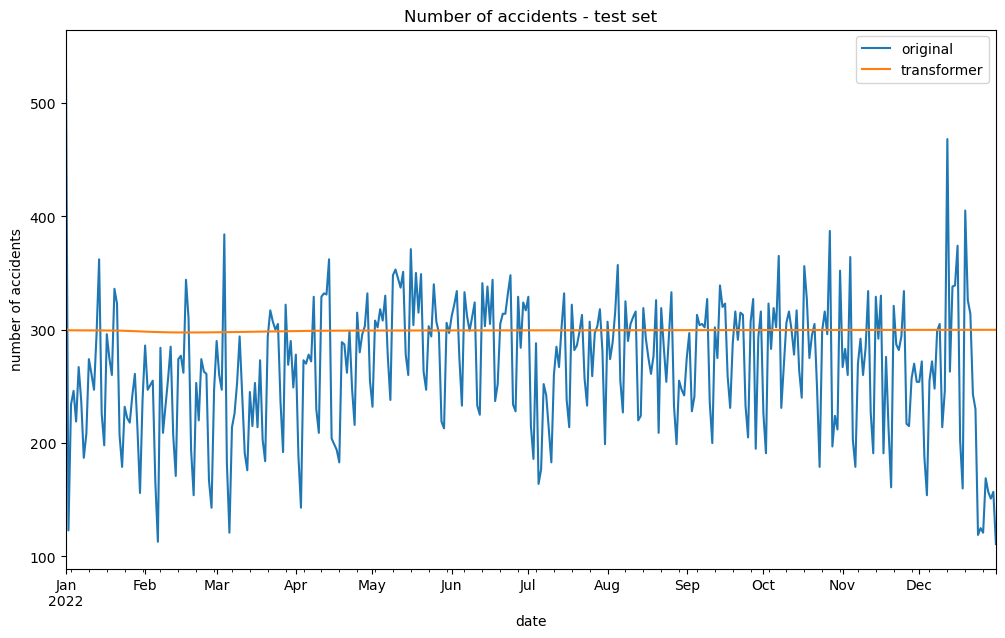

In [257]:
for col in predict_df.columns:
    if col != 'original':
        plt.rcParams['figure.figsize'] = [12, 7]
        predict_df[['original', col]].tail(periods_to_predict + periods_to_predict).head(periods_to_predict).plot()
        plt.title('Number of accidents - test set')
        plt.xlabel('date')
        plt.ylabel('number of accidents')
        plt.show()